<a href="https://colab.research.google.com/github/Allexxandr/data-analytics-project-100/blob/main/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests
import plotly.express as px


In [2]:
!pip install dotenv

In [47]:
from dotenv import load_dotenv

In [48]:
import os

In [49]:
import subprocess

In [6]:
subprocess.run(['git', 'clone', 'https://github.com/Allexxandr/data-analytics-project-100'])

CompletedProcess(args=['git', 'clone', 'https://github.com/Allexxandr/data-analytics-project-100'], returncode=128)

In [7]:
os.chdir('data-analytics-project-100')

In [8]:
load_dotenv()

True

In [50]:
print(os.getcwd())

/content/data-analytics-project-100


In [51]:
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

In [52]:
os.environ['DATE_BEGIN']

'2023-03-01'

In [53]:
url_visit = f'{API_URL}/visits'
params = {
    'begin': DATE_BEGIN,
    'end': DATE_END
}

resp1 = requests.get(url_visit, params=params)
visit = pd.DataFrame(resp1.json())

visit = visit.sort_values(by='datetime')
visit['datetime'] = pd.to_datetime(visit['datetime'])
visit['datetime'] = visit['datetime'].dt.strftime('%Y-%m-%d')
visit = visit.rename(columns={'datetime': 'date'})

visit.head()

,visit_id,platform,user_agent,date
1845,25c1dcbb-cb2d-41dc-88c0-8f5dd8d18483,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-03-01
1560,b09b2b11-0d64-46a2-954a-d8bcd54b207f,web,Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) Apple...,2023-03-01
272,348148db-9841-4b42-a0e1-7631f4667f83,web,Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) Apple...,2023-03-01
81,65f98235-9667-460c-964e-5604b75b48a1,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
607,9b298132-4992-4dff-9d5b-b8741d3b7870,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:15....,2023-03-01


In [54]:
url_reg = f'{API_URL}/registrations'
resp2 = requests.get(url_reg, params=params)
reg = pd.DataFrame(resp2.json())

reg = reg.sort_values(by='datetime')
reg['datetime'] = pd.to_datetime(reg['datetime'])
reg['datetime'] = reg['datetime'].dt.strftime('%Y-%m-%d')
reg = reg.rename(columns={'datetime': 'date'})

reg.head()

,date,user_id,email,platform,registration_type
3,2023-03-01,3e9914e1-5d73-4c23-b25d-b59a3aeb2b60,halldavid@example.org,web,email
28,2023-03-01,b7ec78b7-fdf6-443c-bba6-01e719c26efe,smithrachel@example.net,android,google
22,2023-03-01,2aeb1afe-7641-416f-a21b-d747dbe8d754,kendra89@example.com,android,google
20,2023-03-01,7188b134-a628-4138-9d46-545fb99a91a7,ghernandez@example.net,android,email
55,2023-03-01,93ae2189-9f3c-47ea-ba0a-b06db9fb43ae,lisa22@example.net,android,google


In [55]:
visit.describe()

,visit_id,platform,user_agent,date
count,263459,263459,263459,263459
unique,146085,4,32,184
top,628bc81f-ced7-44cf-818b-a64c194edb44,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-03-08
freq,4,236301,13623,2624


In [56]:
reg.describe()

,date,user_id,email,platform,registration_type
count,21836,21836,21836,21836,21836
unique,184,21836,20868,3,4
top,2023-03-06,a9dfe250-351e-4a01-b4af-c9b31d1f990c,ujones@example.com,android,email
freq,230,1,6,10582,8996


In [57]:
visit_filtered = visit[~visit['user_agent'].str.contains('bot')]

last_visit = (visit_filtered
              .sort_values(['visit_id', 'date'])
              .drop_duplicates(subset=['visit_id'], keep='last'))

visit_group = (last_visit
               .groupby(['date', 'platform'])
               .size()
               .reset_index(name='visits')
               .rename(columns={'date': 'date_group'}))

reg_group = (reg
             .groupby(['date', 'platform'])
             .agg(registrations=('user_id', 'count'))
             .reset_index()
             .rename(columns={'date': 'date_group'}))

conversion = pd.merge(visit_group, reg_group, how='outer', on=['date_group', 'platform']).fillna(0)

conversion['conversion'] = (conversion['registrations'] * 100.0 / conversion['visits']).replace(0, np.nan)

conversion.to_json('./conversion.json')

conversion.head()

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355


In [58]:
ads_campaign = pd.read_csv('https://drive.google.com/uc?export=download&id=12vCtGhJlcK_CBcs8ES3BfEPbk6OJ45Qj')


ads_campaign = ads_campaign.sort_values(by='date')
ads_campaign['date'] = pd.to_datetime(ads_campaign['date']).dt.strftime('%Y-%m-%d')
ads_campaign = ads_campaign.rename(columns={'date': 'date_group'})

ads_cost = ads_campaign.groupby(['date_group', 'utm_campaign'])['cost'].sum().reset_index()

ads_merge = pd.merge(conversion, ads_cost, how='left', on='date_group')
ads_merge = ads_merge.apply(lambda x: x.fillna(0) if x.name != 'utm_campaign' else x)

ads = ads_merge[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]

ads = ads.groupby(['date_group', 'utm_campaign']).sum().reset_index()

ads = ads[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]

ads.to_json('./ads.json')

ads.head(50)

,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,376,87,636.0,advanced_algorithms_series
1,2023-03-02,613,106,756.0,advanced_algorithms_series
2,2023-03-03,683,107,606.0,advanced_algorithms_series
3,2023-03-04,647,159,669.0,advanced_algorithms_series
4,2023-03-05,707,115,795.0,advanced_algorithms_series
5,2023-03-06,1291,230,324.0,advanced_algorithms_series
6,2023-03-07,1382,124,495.0,advanced_algorithms_series
7,2023-03-08,1382,151,465.0,advanced_algorithms_series
8,2023-03-09,1064,209,372.0,advanced_algorithms_series
9,2023-03-10,812,112,828.0,advanced_algorithms_series


In [59]:
os.makedirs('charts', exist_ok=True)

# Verify the directory exists
print(os.listdir())

['data-analytics-project-100', '.env', 'ads.json', 'conversion.json', 'charts', 'README.md', '.github', '.git', 'project.ipynb']


In [60]:
print(os.getcwd())

/content/data-analytics-project-100


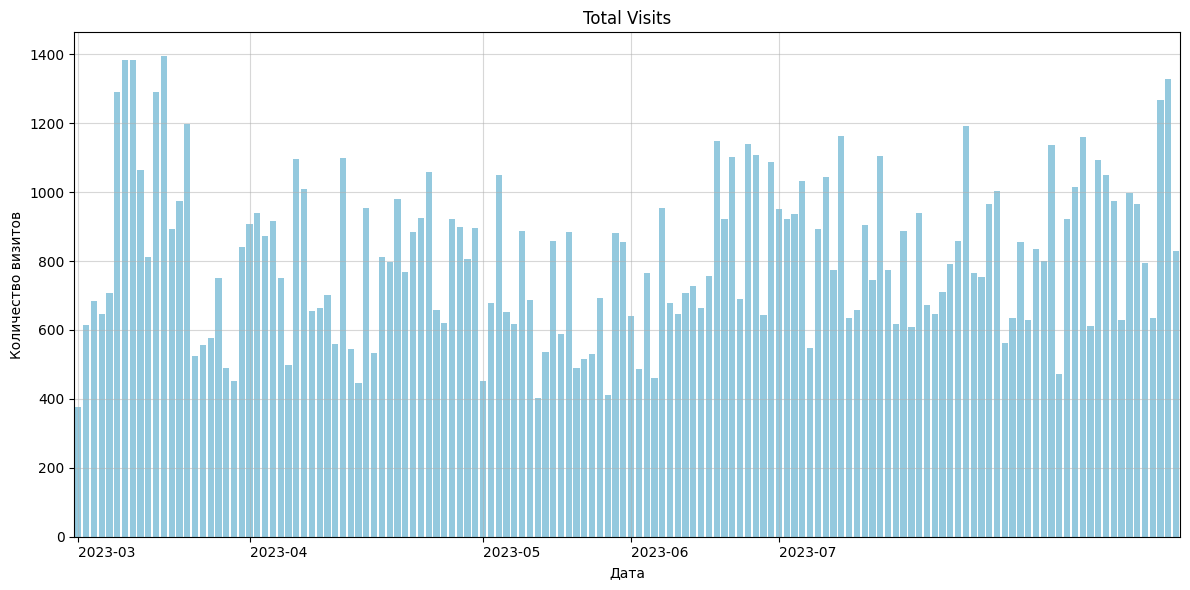

In [61]:
plt.figure(figsize=(12, 6))
sns.barplot(data=ads, x='date_group', y='visits', color='skyblue')

ads['date_group'] = pd.to_datetime(ads['date_group'])
monthly_ticks = ads[ads['date_group'].dt.is_month_start]

plt.xticks(
    ticks=monthly_ticks.index,
    labels=monthly_ticks['date_group'].dt.strftime('%Y-%m'),
    rotation=0,
    ha='left'
)

plt.xlabel('Дата')
plt.ylabel('Количество визитов')
plt.title('Total Visits')
plt.grid(alpha=0.5)
plt.tight_layout()

plt.savefig('./charts/total_visits.png')
plt.show()

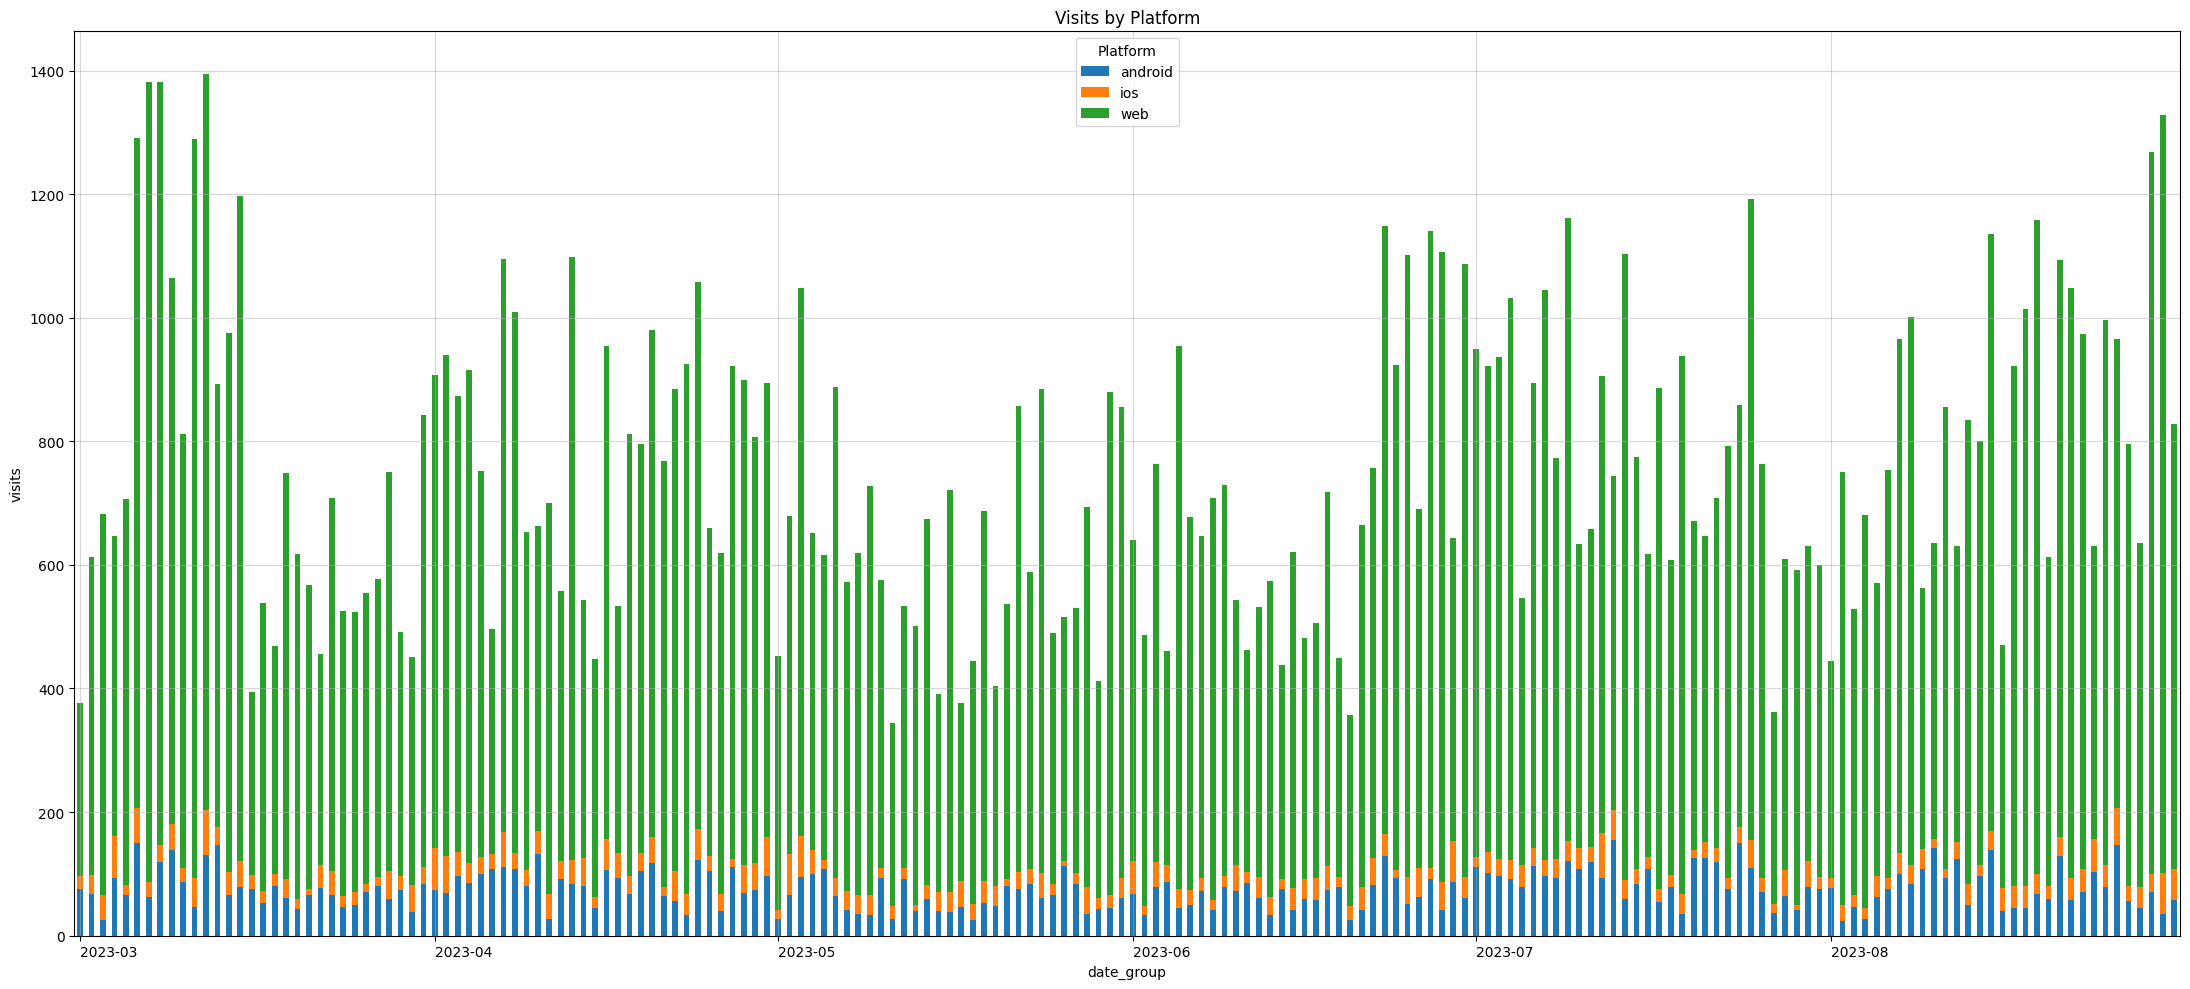

In [62]:
stacked_data_visits = conversion.pivot_table(index='date_group', columns='platform', values='visits', aggfunc='sum', fill_value=0)

plt.figure(figsize=(22, 10))
stacked_data_visits.plot(kind='bar', stacked=True, ax=plt.gca())

plt.xlabel('date_group')
plt.ylabel('visits')
plt.title('Visits by Platform')

stacked_data_visits.index = pd.to_datetime(stacked_data_visits.index)
first_of_month_dates = stacked_data_visits.index[stacked_data_visits.index.day == 1]
first_of_month_dates_positions = [stacked_data_visits.index.get_loc(date) for date in first_of_month_dates]

plt.xticks(first_of_month_dates_positions, labels=first_of_month_dates.strftime('%Y-%m'), rotation=0, ha='left')

plt.grid(alpha=0.5)
plt.legend(title='Platform')

plt.tight_layout()

plt.savefig('./charts/visits_by_platform.png')

KeyError: 'min'

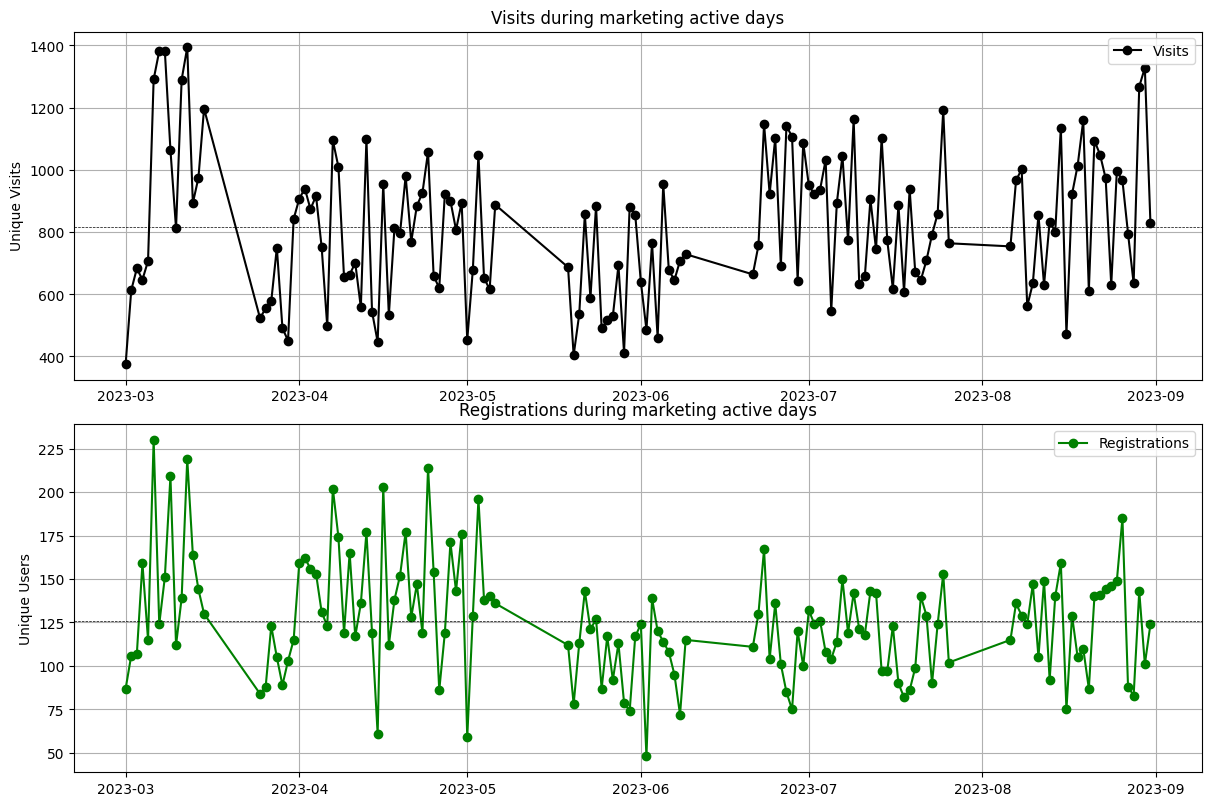

In [63]:
# Create figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Configure layout
plt.tight_layout()

# Plot visits
axes[0].plot('date_group', 'visits',
             marker='o',
             color='black',
             label='Visits',
             data=ads)
axes[0].legend()
axes[0].set_title('Visits during marketing active days')
axes[0].set_ylabel('Unique Visits')
axes[0].grid()
axes[0].axhline(ads['visits'].mean(),
                color='black',
                linestyle='--',
                linewidth=0.5)

# Plot registrations
axes[1].plot('date_group', 'registrations',
             marker='o',
             color='green',
             label='Registrations',
             data=ads)
axes[1].legend()
axes[1].set_title('Registrations during marketing active days')
axes[1].set_ylabel('Unique Users')
axes[1].grid()
axes[1].axhline(ads['registrations'].mean(),
                color='black',
                linestyle='--',
                linewidth=0.5)

# Add campaign spans
campaign_started = ads['min'].to_list()
campaign_ended = ads['max'].to_list()

for i in range(len(campaign_started)):
    axes[0].axvspan(campaign_started[i],
                    campaign_ended[i],
                    alpha=0.3,
                    color=np.random.rand(3,),
                    label=charts['utm_campaign'].to_list()[i])

In [72]:


# Add all changes
subprocess.run(['git', 'add', '.'])

# Create a commit with a message
subprocess.run(['git', 'commit', '-m', 'Your commit message here'])

# Push the changes to GitHub
subprocess.run(['git', 'push'])

CompletedProcess(args=['git', 'push'], returncode=128)

In [71]:
subprocess.run(['git', 'commit', 'https://github.com/Allexxandr/data-analytics-project-100'])

CompletedProcess(args=['git', 'commit', 'https://github.com/Allexxandr/data-analytics-project-100'], returncode=1)

In [70]:
subprocess.run(['git', 'push', 'https://github.com/Allexxandr/data-analytics-project-100'])

CompletedProcess(args=['git', 'push', 'https://github.com/Allexxandr/data-analytics-project-100'], returncode=128)

In [69]:
result = subprocess.run([
    'git',
    'remote',
    'add',
    'origin',
    'https://github.com/Allexxandr/data-analytics-project-100'
])



# Verify remote was added
result = subprocess.run(['git', 'remote', '-v'])
